# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Keyring is skipped due to an exception: 'keyring.backends'


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [ ]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [ ]:
!aws s3 cp dogImages s3://sagemaker-us-east-1-852055550328/Project-3/ --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [4]:
os.environ['SM_CHANNEL_TRAIN'] = 's3://sagemaker-us-east-1-852055550328/Project-3/Data/'
os.environ['SM_CHANNEL_TEST'] = 's3://sagemaker-us-east-1-852055550328/Project-3/Data/'
os.environ['SM_CHANNEL_VAL'] = 's3://sagemaker-us-east-1-852055550328/Project-3/Data/'
inputs = os.environ['SM_CHANNEL_TRAIN']

os.environ['SM_MODEL_DIR'] = 's3://sagemaker-us-east-1-852055550328/Project-3/models/'
os.environ['SM_OUTPUT_DIR'] = 's3://sagemaker-us-east-1-852055550328/Project-3/output/'

In [5]:
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role

from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

#TODO: Create estimators for your HPs


# TODO: Your estimator here
estimator = PyTorch(
    entry_point = "train_model.py",
    base_job_name = "project-3",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.p2.xlarge",
    framework_version = "1.8",
    py_version = "py36",
)

hyperparameter_ranges = {
    "batch_size" : CategoricalParameter([128, 256, 512]),
    "lr" : ContinuousParameter(0.001, 0.1)
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

# TODO: Your HP tuner here
tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs = 4,
    max_parallel_jobs = 1,
    objective_type = objective_type,
)



In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
# TODO: Fit your HP Tuner
tuner.fit({'train': inputs, 'val': inputs, 'test': inputs}, wait = True)


No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
# TODO: Get the best estimators and the best HPs
best_estimator = tuner.best_estimator() #TODO

#Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()
print(best_hyperparameters)


2023-01-05 14:43:55 Starting - Preparing the instances for training
2023-01-05 14:43:55 Downloading - Downloading input data
2023-01-05 14:43:55 Training - Training image download completed. Training in progress.
2023-01-05 14:43:55 Uploading - Uploading generated training model
2023-01-05 14:43:55 Completed - Resource reused by training job: pytorch-training-230105-1353-002-c01b57a0
{'_tuning_objective_metric': '"average test loss"', 'batch_size': '"128"', 'lr': '0.0010825259743175316', 'sagemaker_container_log_level': '20', 'sagemaker_estimator_class_name': '"PyTorch"', 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"', 'sagemaker_job_name': '"project-3-2023-01-05-13-53-30-186"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-852055550328/project-3-2023-01-05-13-53-30-186/source/sourcedir.tar.gz"'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `hpo.py` script to perform model profiling and debugging.

In [5]:
# TODO: Set up debugging and profiling rules and hooks

from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import (
    Rule,
    DebuggerHookConfig,
    rule_configs,
    ProfilerRule,
    CollectionConfig,
    ProfilerConfig,
    FrameworkProfile,
)

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [6]:
profiler_config = ProfilerConfig(
    system_monitor_interval_millis = 500, framework_profile_params = FrameworkProfile(num_steps = 10)
)

In [7]:
collection_configs = [CollectionConfig(name = "CrossEntropyLoss_output_0", 
                                       parameters = {"include_regex": "CrossEntropyLoss_output_0", 
                                                     "train.save_interval": "10", 
                                                     "eval.save_interval": "1"
                                                    }
                                      )
                     ]

hook_config = DebuggerHookConfig(collection_configs = collection_configs)

In [12]:
best_hyperparameters = {'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                        'lr': best_estimator.hyperparameters()['lr']
                       }
print(best_hyperparameters)

{'batch_size': 128, 'lr': '0.0010825259743175316'}


In [8]:
#best_hyperparameters = {'batch_size': 128, 'lr': 0.0010825259743175316}

In [9]:
# TODO: Create and fit an estimator

# TODO: Your estimator here
estimator = PyTorch(
    entry_point = "hpo.py",
    base_job_name = "project-3-best-hyp",
    role = get_execution_role(),
    instance_count = 1,
    instance_type = "ml.p3.2xlarge",
    hyperparameters = best_hyperparameters,
    framework_version = "1.8",
    py_version = "py36",
    rules = rules,
    debugger_hook_config = hook_config,
    profiler_config = profiler_config,
)

In [10]:
estimator.fit({'train': inputs, 'val': inputs, 'test': inputs}, wait = True)

2023-01-06 16:13:26 Starting - Starting the training job...
2023-01-06 16:13:56 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2023-01-06 16:15:16 Downloading - Downloading input data.........
2023-01-06 16:16:57 Training - Downloading the training image...............
2023-01-06 16:19:18 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-01-06 16:19:27,431 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-01-06 16:19:27,458 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-01-06 16:19:27,461 sagemaker_pytorch_container.training INFO     Invoking user training script.
2023-01-06 16:19:27,733 sagemaker-training-toolkit I

In [11]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2023-01-06 16:58:58.645 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:170 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-01-06 16:58:58.661 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:170 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/debug-output
[2023-01-06 16:58:59.076 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:170 WARNING s3handler.py:183] Encountered the exception An error occurred while reading from response stream: ('Connection broken: IncompleteRead(0 bytes read, 4984 more expected)', IncompleteRead(0 bytes read, 4984 more expected)) while reading s3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/debug-output/index/000000000/000000000000_worker_0.json . Will retry now


In [12]:
trial.tensor_names()

[2023-01-06 16:59:46.541 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:170 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-01-06 16:59:47.562 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:170 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.3.bias',
 'gradient/ResNet_fc.3.weight',
 'gradient/ResNet_fc.6.bias',
 'gradient/ResNet_fc.6.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'la

In [13]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode = ModeKeys.TRAIN))

106

In [14]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode = ModeKeys.EVAL))

147

In [15]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode = mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode = mode))
    return steps, vals

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode = ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode = ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize = (10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1, ) = host.plot(steps_train, vals_train, label = tensor_name)
    print("completed TRAIN plot")
    (p2, ) = par.plot(steps_eval, vals_eval, label = "val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    plt.savefig('debug-out.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


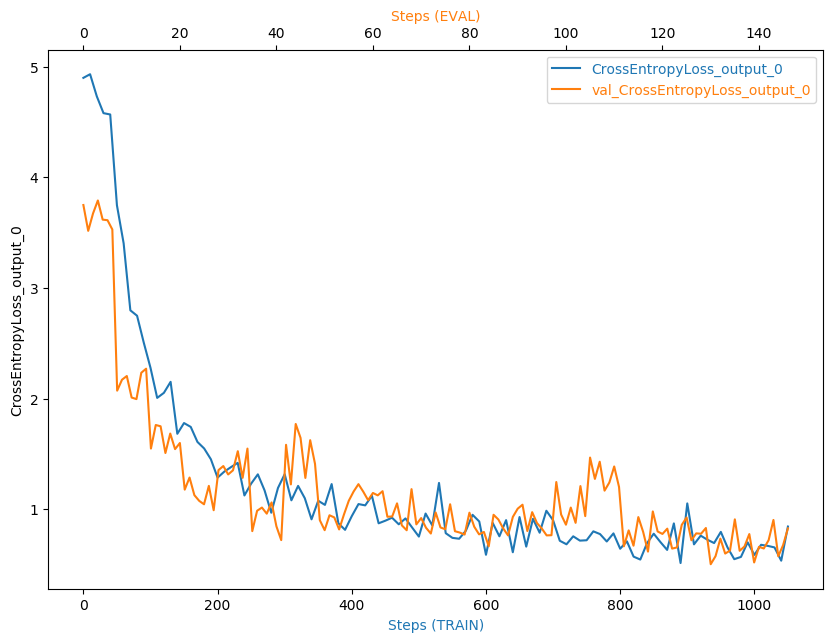

In [17]:
# TODO: Plot a debugging output.

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [18]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [19]:
! aws s3 ls {rule_output_path} --recursive

2023-01-06 16:56:33     462970 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-01-06 16:56:33     326583 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-01-06 16:56:27        553 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-01-06 16:56:27     158320 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-01-06 16:56:27       2031 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-01-06 16:56:27        313 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2023-01-06 16:56:27      10845 project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-outp

In [20]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-8520555

In [21]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename = profiler_report_name + "/profiler-output/profiler-report.html")

In [22]:
import shutil
shutil.make_archive("./profiler_repot", "zip", "ProfilerReport")

'/root/CD0387-deep-learning-topics-within-computer-vision-nlp-project-starter/profiler_repot.zip'

## Model Deploying

In [26]:
#model_location = estimator.model_data

model_location = 's3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-06-16-13-25-619/output/model.tar.gz'

In [27]:
# TODO: Deploy your model to an endpoint
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

instance_type = 'ml.p3.2xlarge'
endpoint_name = 'Project_3-' + instance_type.replace(".","-")
role = sagemaker.get_execution_role()

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

In [28]:
pytorch_model = PyTorchModel(model_data = model_location,
                             role = role, 
                             entry_point = 'inference.py',
                             framework_version = "1.6",
                             py_version = "py36",
                             predictor_cls = ImagePredictor
                            )

In [29]:
predictor = pytorch_model.deploy(initial_instance_count = 1, instance_type = 'ml.p3.2xlarge')

--------!

The dog photo used to do the prediction is:


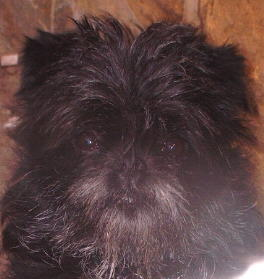

ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (0) from primary with message "Your invocation timed out while waiting for a response from container primary. Review the latency metrics for each container in Amazon CloudWatch, resolve the issue, and try again.". See https://us-east-1.console.aws.amazon.com/cloudwatch/home?region=us-east-1#logEventViewer:group=/aws/sagemaker/Endpoints/pytorch-inference-2023-01-06-17-17-41-656 in account 852055550328 for more information.

In [30]:
# TODO: Run an prediction on the endpoint
from PIL import Image
import io
import os
import numpy as np

files = [
    './dogImages/test/001.Affenpinscher/Affenpinscher_00071.jpg',
    './dogImages/test/027.Bloodhound/Bloodhound_01871.jpg', 
    './dogImages/test/123.Pomeranian/Pomeranian_07873.jpg',
    './dogImages/test/031.Borzoi/Borzoi_02203.jpg',
    './dogImages/test/129.Tibetan_mastiff/Tibetan_mastiff_08140.jpg'
    ]

labels = [27, 123, 31, 129]
    
for i in range(len(files)):
    file = files[i]
    label = labels[i]
    
    # Displaying image to be predicted
    img = Image.open(file)
    print('The dog photo used to do the prediction is:')
    display(img)
    
    # Querying endpoint
    image = open(file, 'rb').read()
    response = predictor.predict(image, initial_args = {'ContentType':'image/jpeg'})
    prediction = np.argmax(response[0]) + 1    
    
    print(f'The label of the image is {label}')
    print(f'The prediction given by the machine learning model is {prediction}\n')


#image = # TODO: Your code to load and preprocess image to send to endpoint for prediction
#response = predictor.predict(image)

In [25]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

In [4]:
#An attempt to infer through boto3

import sagemaker
from sagemaker import image_uris
import time
from time import gmtime, strftime


sess = sagemaker.session.Session()

bucket = sess.default_bucket()
print("Default Bucket: {}".format(bucket))

region = sess.boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.session.get_execution_role(sess)
print("RoleArn: {}".format(role))


# Specify an AWS container image. 
container = image_uris.retrieve(framework = 'pytorch',
                                region = region,
                                version = '1.8.0',
                                py_version = 'py36', 
                                image_scope = 'inference', 
                                instance_type = 'ml.m5.xlarge'
                               )

print(container)


model_file_name = "Project3-image-classification"
model_name = model_file_name + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
model_url = "https://sagemaker-us-east-1-852055550328.s3.amazonaws.com/project-3-best-hyp-2023-01-05-17-14-39-639/output/model.tar.gz"
sm_client = boto3.client("sagemaker")

print(model_url)

primary_container = {
    "Image": container,
    "ModelDataUrl": model_url,
}

create_model_response2 = sm_client.create_model(ModelName = model_name, 
                                                ExecutionRoleArn = role, 
                                                PrimaryContainer = primary_container
)

print(create_model_response2["ModelArn"])


endpoint_config_name = "Project3-EndpointConfig-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_config_name)

create_endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])


endpoint_name = "Project3-EndpointConfig-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print(endpoint_name)

create_endpoint_response = sm_client.create_endpoint(
    EndpointName = endpoint_name, EndpointConfigName = endpoint_config_name
)
print(create_endpoint_response["EndpointArn"])

resp = sm_client.describe_endpoint(EndpointName = endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName = endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)


runtime_client = boto3.client("runtime.sagemaker")

#sm_client.delete_endpoint(EndpointName = endpoint_name)


Default Bucket: sagemaker-us-east-1-852055550328
AWS Region: us-east-1
RoleArn: arn:aws:iam::852055550328:role/service-role/AmazonSageMaker-ExecutionRole-20221119T214340


In [8]:
#Another attempt to infer

from sagemaker.model import Model
from datetime import datetime

model_location = 's3://sagemaker-us-east-1-852055550328/project-3-best-hyp-2023-01-05-17-14-39-639/output/model.tar.gz'

model = Model(image_uri = container,
              model_data = model_location, 
              role = role)

endpoint_name = f"DEMO-{datetime.utcnow():%Y-%m-%d-%H%M}"
print("EndpointName =", endpoint_name)

model.deploy(initial_instance_count = 1, 
             instance_type = 'ml.m5.xlarge',
             endpoint_name = endpoint_name
)

In [32]:
#Inference using batch transform

sagemaker_session = sagemaker.Session()
role = get_execution_role()

bucket = sagemaker_session.default_bucket()
prefix = "inference/batch_transform"
print("Bucket: {}".format(bucket))


transformer = pytorch_model.transformer(instance_count = 1, instance_type = 'ml.m5.xlarge')


transformer.transform(
    data = 's3://sagemaker-us-east-1-852055550328/Project-3/Data/test/031.Borzoi/',
    data_type = "S3Prefix",
    content_type = "image/jpeg",
    wait = True,
)


# look at the status of the transform job
import pprint as pp

sm_cli = sagemaker_session.sagemaker_client

job_info = sm_cli.describe_transform_job(TransformJobName = transformer.latest_transform_job.name)

pp.pprint(job_info)

Bucket: sagemaker-us-east-1-852055550328
